In [70]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix, plot_roc_curve, classification_report


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [71]:
%%time

df = pd.read_pickle(r'Loan_status_2007-2020Q3.pkl')

CPU times: user 8.04 s, sys: 5.82 s, total: 13.9 s
Wall time: 13.8 s


In [72]:
df.shape

(2925493, 141)

In [73]:
df_dict = pd.read_excel(r'LCDataDictionary.xlsx', index_col=0)

In [74]:
pd.set_option('display.max_rows', 1000, 'display.max_columns', 1000,
              "display.max_colwidth", None, 'display.width', None, 'display.max_info_columns', 200)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077501,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2020,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1077430,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077430,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,1077175,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=1077175,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2

In [75]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=141)

In [76]:
df['loan_status'].value_counts()

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
Name: loan_status, dtype: int64

In [77]:
df = df[df['loan_status'].isin(
    ['Fully Paid', 'Charged Off'])].reset_index(drop=True)

In [78]:
df.shape
#(1860331, 141)

(1860331, 141)

In [79]:
df.info()
# float64(106), object(35)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860331 entries, 0 to 1860330
Data columns (total 141 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    id                                          object 
 1    loan_amnt                                   float64
 2    funded_amnt                                 float64
 3    funded_amnt_inv                             float64
 4    term                                        object 
 5    int_rate                                    object 
 6    installment                                 float64
 7    grade                                       object 
 8    sub_grade                                   object 
 9    emp_title                                   object 
 10   emp_length                                  object 
 11   home_ownership                              object 
 12   annual_inc                                  float64
 13   verificati

In [80]:
def get_df_info(df):
    null_info = df.isnull().sum().to_frame(name='#null')
    null_info['%null'] = round(100 * null_info['#null'] / len(df), 2)
    df_info = pd.concat([null_info, df.describe(include='all').T], axis=1)
    df_info = df_info.sort_values(by='%null', ascending=False)

    return df_info

In [81]:
df_stat = get_df_info(df)
df_stat

,#null,%null,count,unique,top,freq,mean,std,min,25%,50%,75%,max
next_pymnt_d,1860331,100.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_plan_start_date,1847636,99.32,12695,44,Sep-2017,1530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_type,1847636,99.32,12695,5,INTEREST ONLY-3 MONTHS DEFERRAL,9706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_reason,1847635,99.32,12696,17,NATURAL_DISASTER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_status,1847636,99.32,12695,4,COMPLETED,6870,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deferral_term,1847636,99.32,12695.0,NaN,NaN,NaN,2.853013,0.357208,0.0,3.0,3.0,3.0,4.0
hardship_start_date,1847636,99.32,12695,45,Sep-2017,2158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_end_date,1847636,99.32,12695,45,Dec-2017,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hardship_length,1847636,99.32,12695.0,NaN,NaN,NaN,2.853013,0.357208,0.0,3.0,3.0,3.0,4.0
hardship_dpd,1847636,99.32,12695.0,NaN,NaN,NaN,12.27822,9.984442,0.0,0.0,13.0,21.0,38.0


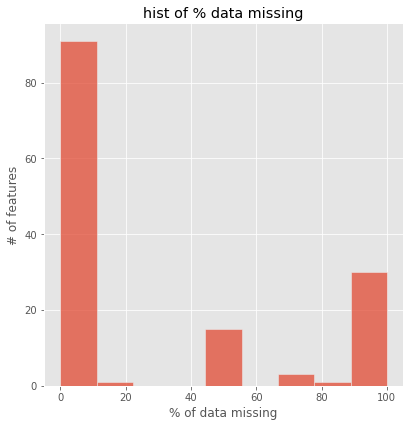

In [82]:
sns.displot(data=df_stat, x='%null', aspect=1, height=5.8)
plt.title('hist of % data missing')
plt.xlabel('% of data missing')
plt.ylabel('# of features')
plt.show()

In [83]:
col_drop = [index for index in df_stat.index if df_stat.loc[index]['%null'] > 50]
len(col_drop)  # 36

36

In [84]:
df = df.drop(col_drop, axis=1)

In [85]:
df.shape
#(1860331, 105)

(1860331, 105)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860331 entries, 0 to 1860330
Data columns (total 105 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    id                          object 
 1    loan_amnt                   float64
 2    funded_amnt                 float64
 3    funded_amnt_inv             float64
 4    term                        object 
 5    int_rate                    object 
 6    installment                 float64
 7    grade                       object 
 8    sub_grade                   object 
 9    emp_title                   object 
 10   emp_length                  object 
 11   home_ownership              object 
 12   annual_inc                  float64
 13   verification_status         object 
 14   issue_d                     object 
 15   loan_status                 object 
 16   pymnt_plan                  object 
 17   url                         object 
 18   purpose                     object 
 19 

In [87]:
df_dict = df_dict[['Description']]

In [88]:
df_dict.loc['total_rec_prncp']

Description    Principal received to date
Name: total_rec_prncp, dtype: object

In [89]:
df['revol_util']

0          83.7%
1           9.4%
2          98.5%
3            21%
4          53.9%
           ...  
1860326    24.9%
1860327    15.7%
1860328      47%
1860329    10.1%
1860330    72.6%
Name: revol_util, Length: 1860331, dtype: object

In [90]:
cont_var = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
            'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
            'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int']
cate_var = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
            'purpose', 'application_type']

print('number of continuous variable :' + str(len(cont_var))
      + '\n' + 'number of categorical variable: ' + str(len(cate_var)))

number of continuous variable :17
number of categorical variable: 7


In [91]:
df['revol_util'] = df['revol_util'].str.replace(r'%', '').astype('float') / 100
df['int_rate'] = df['int_rate'].str.replace(r'%', '').astype('float') / 100

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860331 entries, 0 to 1860330
Data columns (total 105 columns):
 #    Column                      Dtype  
---   ------                      -----  
 0    id                          object 
 1    loan_amnt                   float64
 2    funded_amnt                 float64
 3    funded_amnt_inv             float64
 4    term                        object 
 5    int_rate                    float64
 6    installment                 float64
 7    grade                       object 
 8    sub_grade                   object 
 9    emp_title                   object 
 10   emp_length                  object 
 11   home_ownership              object 
 12   annual_inc                  float64
 13   verification_status         object 
 14   issue_d                     object 
 15   loan_status                 object 
 16   pymnt_plan                  object 
 17   url                         object 
 18   purpose                     object 
 19 

In [93]:
col_keep = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
            'term', 'int_rate', 'installment', 'grade', 'annual_inc',
            'emp_length', 'home_ownership', 'verification_status',
            'purpose',  'dti', 'delinq_2yrs',
            'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
            'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
            'total_rec_int', 'application_type', 'loan_status']
len(col_keep)  # 25

25

In [94]:
col_drop = [col for col in df.columns if col not in col_keep]

In [95]:
df = df.drop(col_drop, axis=1)

In [96]:
df.shape
#(1860331, 25)

(1860331, 25)

In [97]:
get_df_info(df)

,#null,%null,count,unique,top,freq,mean,std,min,25%,50%,75%,max
emp_length,117196,6.30,1743135,11,10+ years,611330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_util,1398,0.08,1858933.0,NaN,NaN,NaN,0.504643,0.247899,0.0,0.316,0.505,0.696,8.923
dti,1108,0.06,1859223.0,NaN,NaN,NaN,18.567739,13.091529,-1.0,11.82,17.71,24.29,999.0
loan_amnt,0,0.00,1860331.0,NaN,NaN,NaN,14588.272544,8970.471416,500.0,7950.0,12000.0,20000.0,40000.0
total_rec_int,0,0.00,1860331.0,NaN,NaN,NaN,2513.191438,2754.893054,0.0,777.15,1603.05,3188.465,31714.37
total_rec_prncp,0,0.00,1860331.0,NaN,NaN,NaN,12386.011506,9069.622873,0.0,5060.1,10000.0,18000.0,40000.0
total_pymnt_inv,0,0.00,1860331.0,NaN,NaN,NaN,15150.045436,10677.649419,0.0,6887.26,12288.49,21090.525,67174.38
total_pymnt,0,0.00,1860331.0,NaN,NaN,NaN,15168.620221,10679.153976,0.0,6904.604776,12303.466101,21110.644169,67174.381813
total_acc,0,0.00,1860331.0,NaN,NaN,NaN,24.59665,12.046282,2.0,16.0,23.0,31.0,176.0
revol_bal,0,0.00,1860331.0,NaN,NaN,NaN,16285.408134,22468.1126,0.0,5842.0,11070.0,19770.0,2904836.0


In [98]:
df = df.dropna(axis=0, subset = ['inq_last_6mths','dti','revol_util']).reset_index(drop=True)

In [99]:
get_df_info(df)

,#null,%null,count,unique,top,freq,mean,std,min,25%,50%,75%,max
emp_length,116064,6.25,1741764,11,10+ years,610867,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,0,0.00,1857828.0,NaN,NaN,NaN,14587.606926,8967.236999,500.0,7975.0,12000.0,20000.0,40000.0
dti,0,0.00,1857828.0,NaN,NaN,NaN,18.569844,13.072254,-1.0,11.83,17.72,24.29,999.0
total_rec_int,0,0.00,1857828.0,NaN,NaN,NaN,2513.677709,2755.111692,0.0,777.54,1603.37,3189.0525,31714.37
total_rec_prncp,0,0.00,1857828.0,NaN,NaN,NaN,12386.0321,9066.81533,0.0,5069.52,10000.0,18000.0,40000.0
total_pymnt_inv,0,0.00,1857828.0,NaN,NaN,NaN,15150.549094,10675.289976,0.0,6890.525,12290.41,21089.805,67174.38
total_pymnt,0,0.00,1857828.0,NaN,NaN,NaN,15169.121541,10676.807945,0.0,6907.999706,12305.480308,21109.934,67174.381813
total_acc,0,0.00,1857828.0,NaN,NaN,NaN,24.605004,12.045792,2.0,16.0,23.0,31.0,176.0
revol_util,0,0.00,1857828.0,NaN,NaN,NaN,0.504659,0.247881,0.0,0.316,0.505,0.696,8.923
revol_bal,0,0.00,1857828.0,NaN,NaN,NaN,16289.953096,22416.285482,0.0,5851.0,11078.0,19775.0,2904836.0


In [100]:
df['emp_length'].value_counts(normalize=True) * 100

10+ years    35.071743
2 years       9.668072
< 1 year      8.812388
3 years       8.564765
1 year        7.050898
5 years       6.648145
4 years       6.438013
6 years       4.896588
8 years       4.512207
7 years       4.483041
9 years       3.854139
Name: emp_length, dtype: float64

<AxesSubplot:xlabel='emp_length', ylabel='count'>

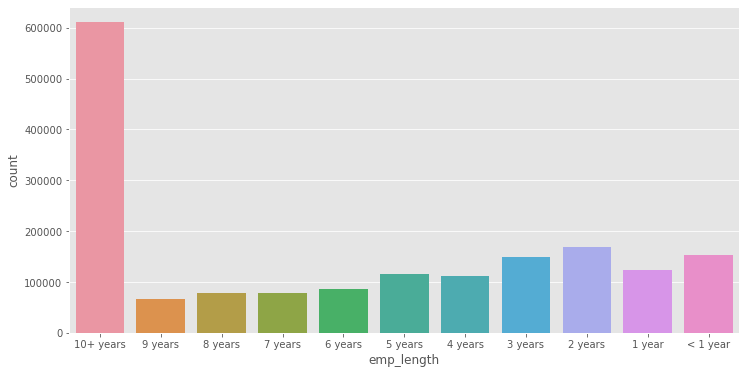

In [101]:
plt.figure(figsize=(12,6))

sns.countplot('emp_length', data=df, order=['10+ years', '9 years', '8 years',
                                            '7 years', '6 years', '5 years',
                                            '4 years', '3 years', '2 years',
                                             '1 year', '< 1 year']) 

In [102]:
df.describe(include='object').T

,count,unique,top,freq
term,1857828,2,36 months,1391496
grade,1857828,7,B,546010
emp_length,1741764,11,10+ years,610867
home_ownership,1857828,6,MORTGAGE,916606
verification_status,1857828,3,Source Verified,733478
loan_status,1857828,2,Fully Paid,1495771
purpose,1857828,14,debt_consolidation,1062229
application_type,1857828,2,Individual,1789583


In [103]:
round(df['purpose'].value_counts(normalize=True) * 100, 2)

debt_consolidation    57.18
credit_card           22.20
home_improvement       6.65
other                  6.10
major_purchase         2.24
medical                1.21
small_business         1.10
car                    1.09
vacation               0.72
moving                 0.71
house                  0.60
wedding                0.12
renewable_energy       0.07
educational            0.02
Name: purpose, dtype: float64

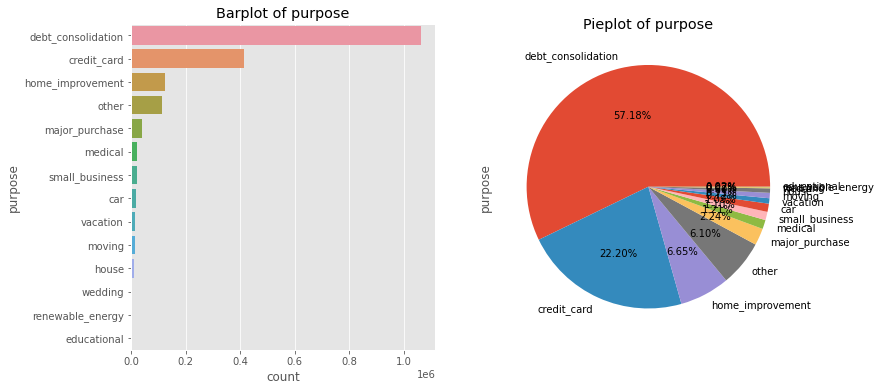

In [104]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.countplot(y='purpose', data=df, order=df['purpose'].value_counts().index, ax=ax[0])
ax[0].set_title('Barplot of purpose')

df['purpose'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1])
ax[1].set_title('Pieplot of purpose')
plt.show()

In [105]:
df.loc[df['purpose'] == 'house', 'purpose'] = 'home_improvement'
df.loc[df['purpose'].isin(['educational','renewable_energy','wedding','moving','vacation']), 'purpose'] = 'other'
df.loc[df['purpose'].isin(['medical','small_business','car']), 'purpose'] = 'major_purchase'

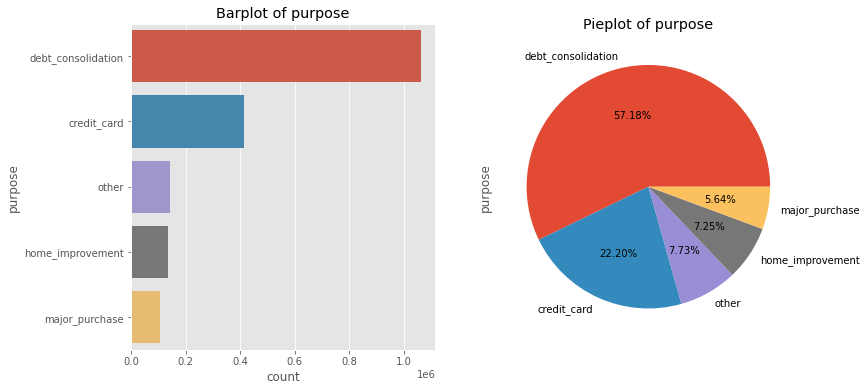

In [106]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.countplot(y='purpose', data=df, order=df['purpose'].value_counts().index, ax=ax[0])
ax[0].set_title('Barplot of purpose')

df['purpose'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1])
ax[1].set_title('Pieplot of purpose')
plt.show()

In [107]:
df['annual_inc'].describe()

count    1.857828e+06
mean     7.740215e+04
std      1.178220e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.200000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

In [108]:
df['annual_inc']

0           24000.0
1           30000.0
2           12252.0
3           49200.0
4           80000.0
             ...   
1857823    107000.0
1857824     65000.0
1857825     37000.0
1857826     41000.0
1857827    105700.0
Name: annual_inc, Length: 1857828, dtype: float64

In [109]:
annual_inc_l_bins = [-np.inf, 25000, 50000, 75000, 100000,
                     150000,  200000, np.inf]
annual_inc_labels = ['25000', '50000', '75000', '100000',
                     '150000', '200000', '>200000']
df['annual_inc_bins'] = pd.cut(
    df['annual_inc'], bins=annual_inc_l_bins, labels=annual_inc_labels)

In [110]:
df[['annual_inc','annual_inc_bins']]

,annual_inc,annual_inc_bins
0,24000.0,25000
1,30000.0,50000
2,12252.0,25000
3,49200.0,50000
4,80000.0,100000
...,...,...
1857823,107000.0,150000
1857824,65000.0,75000
1857825,37000.0,50000
1857826,41000.0,50000


In [111]:
df['annual_inc_bins'].value_counts(normalize=True)* 100

75000      30.304528
50000      27.864205
100000     18.620938
150000     13.630218
25000       3.908543
200000      3.422168
>200000     2.249401
Name: annual_inc_bins, dtype: float64

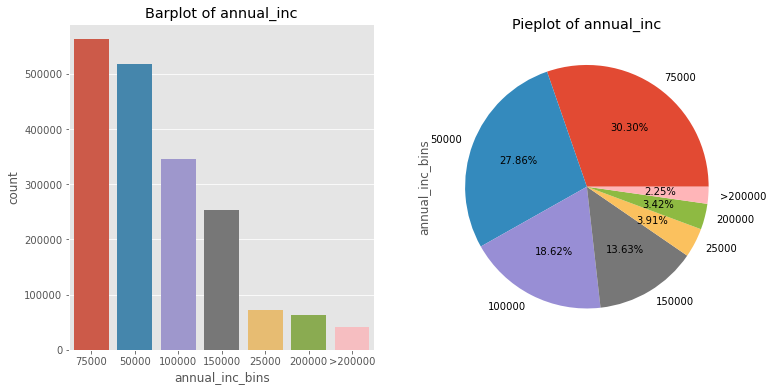

In [112]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.countplot(x='annual_inc_bins', data=df, order=df['annual_inc_bins'].value_counts().index, ax=ax[0])
ax[0].set_title('Barplot of annual_inc')

df['annual_inc_bins'].value_counts().plot.pie(autopct='%.2f%%', ax=ax[1])
ax[1].set_title('Pieplot of annual_inc')
plt.show()

In [113]:
df = df.drop('annual_inc', axis=1)

In [114]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'application_type', 'annual_inc_bins'],
      dtype='object')

In [115]:
df.shape

(1857828, 25)

In [116]:
df.describe(include='object').T

,count,unique,top,freq
term,1857828,2,36 months,1391496
grade,1857828,7,B,546010
emp_length,1741764,11,10+ years,610867
home_ownership,1857828,6,MORTGAGE,916606
verification_status,1857828,3,Source Verified,733478
loan_status,1857828,2,Fully Paid,1495771
purpose,1857828,5,debt_consolidation,1062229
application_type,1857828,2,Individual,1789583


In [117]:
#target variable encoding

df['loan_status'] = df['loan_status'].apply(lambda x: ['Fully Paid', 'Charged Off'].index(x))

In [118]:
df['loan_status']

0          0
1          1
2          0
3          0
4          0
          ..
1857823    1
1857824    0
1857825    1
1857826    0
1857827    1
Name: loan_status, Length: 1857828, dtype: int64

In [119]:
#categorical variables encoding
cate_dummies = ['term', 'home_ownership', 'verification_status', 'purpose', 'application_type']
df = pd.get_dummies(df, columns=cate_dummies)

In [120]:
df.shape

(1857828, 38)

In [121]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'emp_length', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'annual_inc_bins', 'term_ 36 months',
       'term_ 60 months', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'purpose_other',
       'application_type_Individual', 'application_type_Joint App'],
      dtype='object')

In [122]:
#ordinal variables

df['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [123]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [124]:
mapping = {
    'grade':{
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7
    },
    'emp_length':{
        np.NAN: 0,
       '< 1 year': 0,
        '1 year': 1,
        '2 years': 2,
        '3 years': 3,
        '4 years': 4,
        '5 years': 5,
        '6 years': 6,
        '7 years': 7,
        '8 years': 8,
        '9 years': 9,
        '10+ years': 10       
        },
    'annual_inc_bins':{
        '25000': 1,
        '50000': 2,
        '75000': 3,
        '100000': 4,
        '150000': 5,
        '200000': 6,
        '>200000': 7
        }  
    }

In [125]:
df = df.replace(mapping)

In [126]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,emp_length,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,annual_inc_bins,term_ 36 months,term_ 60 months,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_major_purchase,purpose_other,application_type_Individual,application_type_Joint App
0,5000.0,5000.0,4975.0,0.1065,162.87,2,10,0,27.65,0.0,1.0,3.0,13648.0,0.837,9.0,5863.155187,5833.84,5000.00,863.16,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,2500.0,2500.0,2500.0,0.1527,59.83,3,0,1,1.00,0.0,5.0,3.0,1687.0,0.094,4.0,1014.530000,1014.53,456.46,435.17,2,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0
2,2400.0,2400.0,2400.0,0.1596,84.33,3,10,0,8.72,0.0,2.0,2.0,2956.0,0.985,10.0,3005.666844,3005.67,2400.00,605.67,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
3,10000.0,10000.0,10000.0,0.1349,339.31,3,10,0,20.00,0.0,1.0,10.0,5598.0,0.210,37.0,12231.890000,12231.89,10000.00,2214.92,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0
4,3000.0,3000.0,3000.0,0.1269,67.79,2,1,0,17.94,0.0,0.0,15.0,27783.0,0.539,38.0,4066.908161,4066.91,3000.00,1066.91,4,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0


In [127]:
# sort_index = df.isnull().sum().sort_values().to_frame(name='counts')
# sort_index = sort_index[sort_index['counts'] > 0].index.to_list()
# sort_index

In [128]:
# %%time

# for i in sort_index:
#     df_process = df.copy()
#     fill_missing = df_process.loc[:,i]
#     df_fill_0 = df_process.drop(i, axis=1).fillna(value=0)
    
#     Ytrain = fill_missing[fill_missing.notnull()]
#     Ytest = fill_missing[fill_missing.isnull()]
#     Xtrain = df_fill_0.iloc[Ytrain.index,:]
#     Xtest = df_fill_0.iloc[Ytest.index,:]
#     rfc = RandomForestClassifier(n_estimators=50, max_depth=4).fit(Xtrain, Ytrain)
#     y_pred = rfc.predict(Xtest)
    
#     df.loc[df.loc[:,i].isnull(),i] = y_pred    

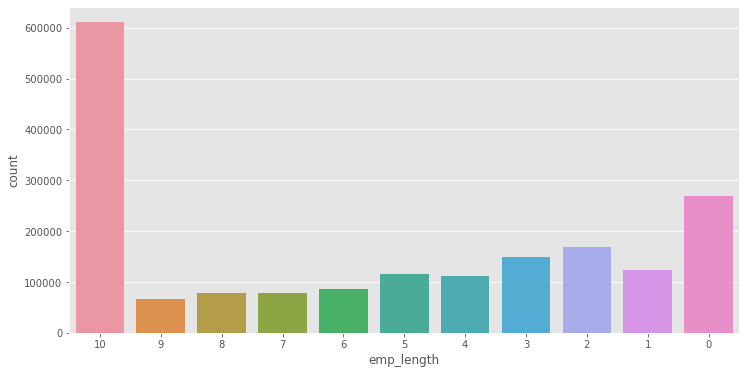

In [129]:
plt.figure(figsize=(12,6))

sns.countplot('emp_length', data=df, order=range(10,-1,-1))

plt.show()

In [130]:
get_df_info(df)

,#null,%null,count,mean,std,min,25%,50%,75%,max
loan_amnt,0,0.0,1857828.0,14587.606926,8967.236999,500.0000,7975.000000,12000.000000,20000.0000,4.000000e+04
verification_status_Not Verified,0,0.0,1857828.0,0.315970,0.464901,0.0000,0.000000,0.000000,1.0000,1.000000e+00
term_ 60 months,0,0.0,1857828.0,0.251009,0.433594,0.0000,0.000000,0.000000,1.0000,1.000000e+00
home_ownership_ANY,0,0.0,1857828.0,0.000631,0.025119,0.0000,0.000000,0.000000,0.0000,1.000000e+00
home_ownership_MORTGAGE,0,0.0,1857828.0,0.493375,0.499956,0.0000,0.000000,0.000000,1.0000,1.000000e+00
home_ownership_NONE,0,0.0,1857828.0,0.000026,0.005136,0.0000,0.000000,0.000000,0.0000,1.000000e+00
home_ownership_OTHER,0,0.0,1857828.0,0.000076,0.008742,0.0000,0.000000,0.000000,0.0000,1.000000e+00
home_ownership_OWN,0,0.0,1857828.0,0.110510,0.313525,0.0000,0.000000,0.000000,0.0000,1.000000e+00
home_ownership_RENT,0,0.0,1857828.0,0.395381,0.488932,0.0000,0.000000,0.000000,1.0000,1.000000e+00
verification_status_Source Verified,0,0.0,1857828.0,0.394804,0.488809,0.0000,0.000000,0.000000,1.0000,1.000000e+00


In [131]:
np.abs(pd.DataFrame(df.corr())['loan_status'])

loan_amnt                              0.071878
funded_amnt                            0.071909
funded_amnt_inv                        0.071756
int_rate                               0.253341
installment                            0.059842
grade                                  0.250774
emp_length                             0.033345
loan_status                            1.000000
dti                                    0.064042
delinq_2yrs                            0.014083
inq_last_6mths                         0.064937
open_acc                               0.021168
revol_bal                              0.022214
revol_util                             0.049435
total_acc                              0.015619
total_pymnt                            0.293239
total_pymnt_inv                        0.292929
total_rec_prncp                        0.421074
total_rec_int                          0.051418
annual_inc_bins                        0.060087
term_ 36 months                        0

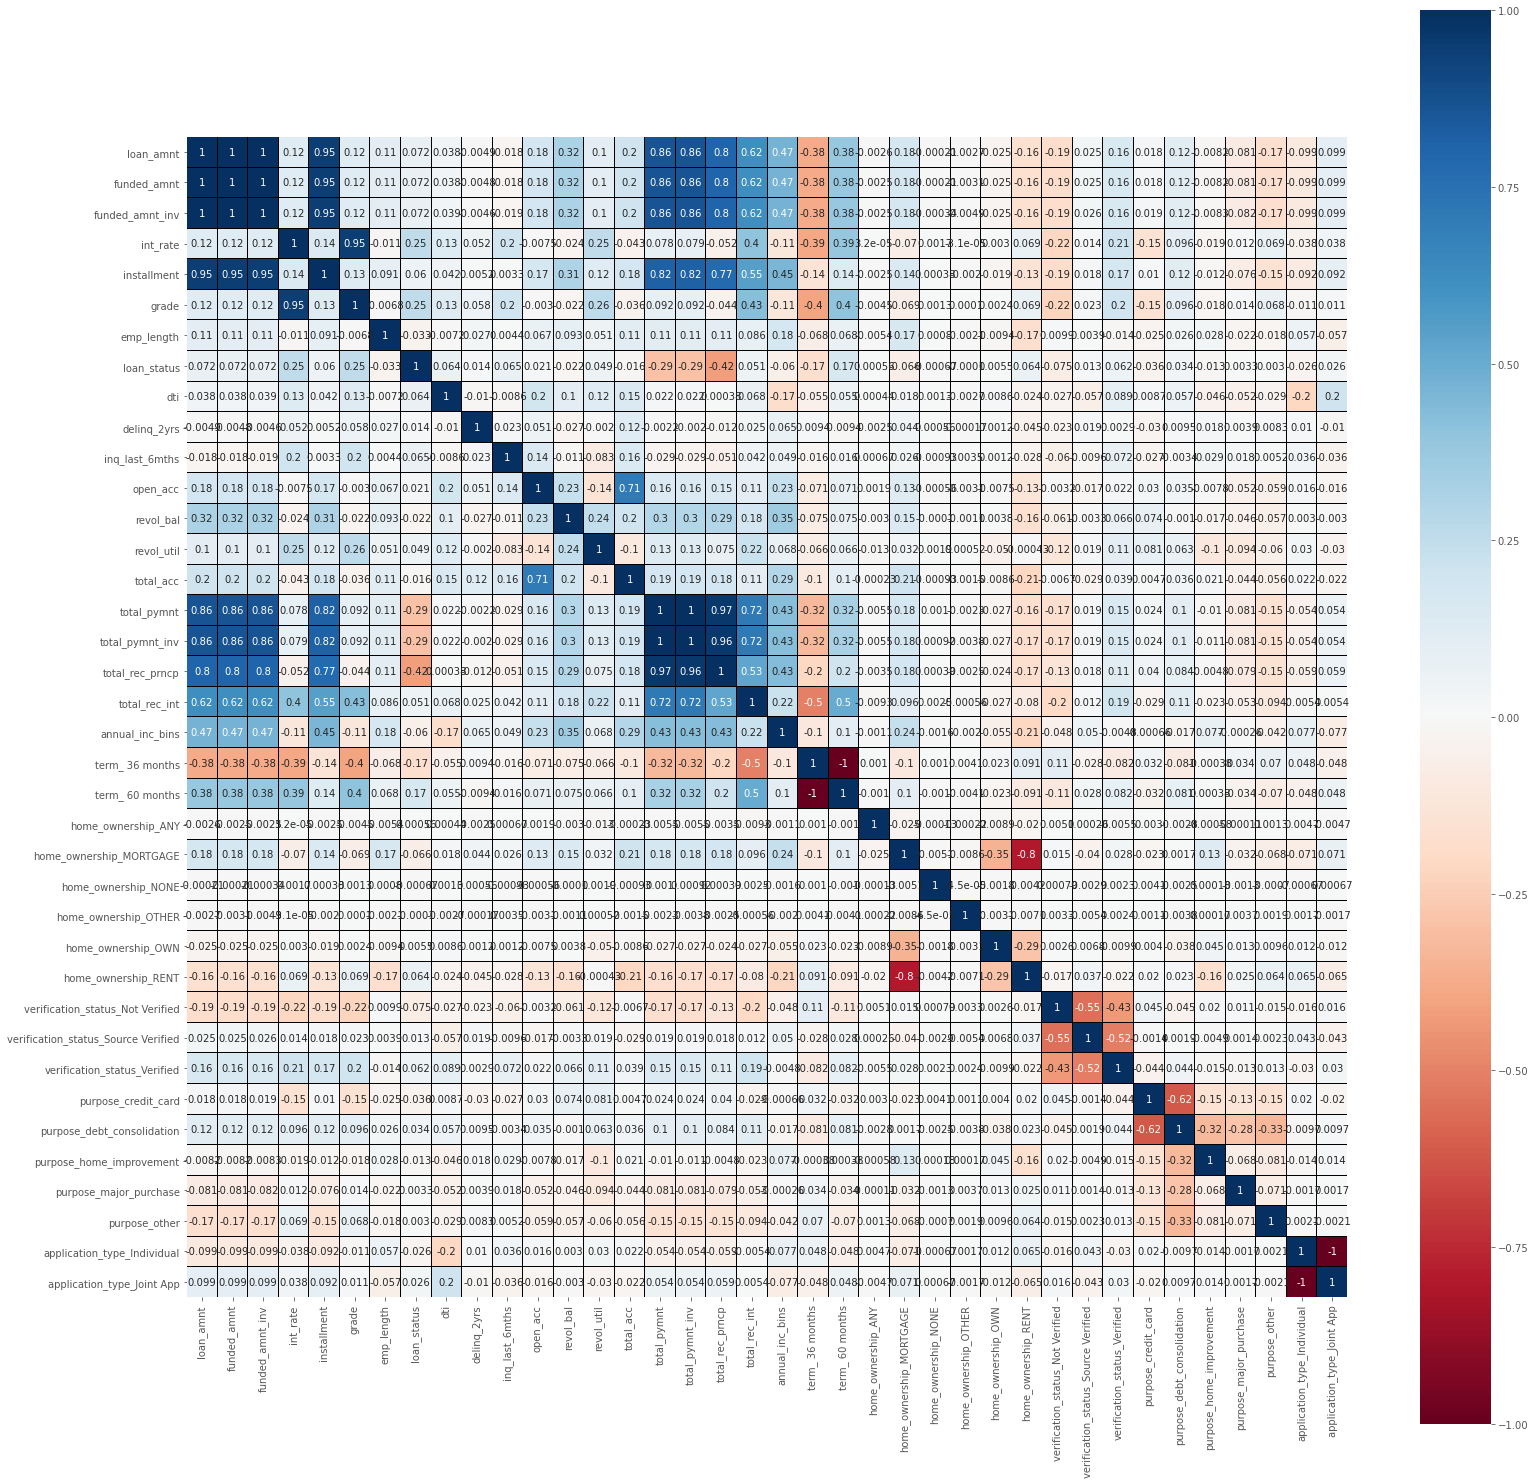

CPU times: user 38 s, sys: 3.47 s, total: 41.5 s
Wall time: 41.5 s


In [132]:
%%time

plt.figure(figsize = (26,26))

sns.heatmap(df.corr(),  linewidths = .01, vmax=1.0, square = True, annot=True, cmap = 'RdBu', linecolor = 'black')

plt.show()

In [135]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'emp_length', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'annual_inc_bins', 'term_ 36 months',
       'term_ 60 months', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_major_purchase', 'purpose_other',
       'application_type_Individual', 'application_type_Joint App'],
      dtype='object')

In [136]:
col_drop = ['funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 
            'total_pymnt_inv', 'total_rec_prncp','total_rec_int', 'int_rate',
            'open_acc', 'term_ 36 months', 'home_ownership_RENT', 'purpose_debt_consolidation',
            'application_type_Joint App']

In [137]:
df = df.drop(col_drop, axis=1)

In [138]:
df.shape

(1857828, 25)

In [139]:
# get mini dataset

df_mini = df.sample(frac=0.1, random_state=2021).reset_index(drop=True)

In [140]:
df_mini.to_csv(r'Loan_status_2007-2020Q3_mini.csv', index=None)

In [141]:
# model fitting
# LR alone

X = df_mini.drop('loan_status', axis=1)
y = df_mini['loan_status']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=2021)

print('sample number of train set: ' + str(len(Ytrain))
      + '\n' + 'sample number of test set: ' + str(len(Ytest)))

sample number of train set: 130048
sample number of test set: 55735


In [142]:
X.columns

Index(['loan_amnt', 'grade', 'emp_length', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'revol_bal', 'revol_util', 'total_acc',
       'annual_inc_bins', 'term_ 60 months', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_other',
       'application_type_Individual'],
      dtype='object')

In [143]:
Ytrain.value_counts(normalize=True) * 100

0    80.486436
1    19.513564
Name: loan_status, dtype: float64

In [144]:
%%time

Xtrain, Ytrain = SMOTE(random_state=2021, n_jobs=-1).fit_resample(Xtrain,Ytrain)
Ytrain.value_counts(normalize=True) * 100

# CPU times: user 47min 26s, sys: 1h 39min 11s, total: 2h 26min 37s
# Wall time: 23min 38s

CPU times: user 1min 5s, sys: 13.1 s, total: 1min 18s
Wall time: 25.1 s


0    50.0
1    50.0
Name: loan_status, dtype: float64

In [145]:
%%time


param_grid_lr = [{'C': [0.01, 0.1, 1, 10, ], 'penalty': ['l2'],},
              {'C': [0.01, 0.1, 1, 10, ], 'penalty': ['l1'],'solver': ['liblinear'],}
             ]

grid_search_lr = GridSearchCV(LogisticRegression(n_jobs=-1),  param_grid_lr, scoring='roc_auc', cv=5, n_jobs=-1) 
grid_search_lr.fit(Xtrain, Ytrain)

# Wall time: 4min 29s

CPU times: user 12.4 s, sys: 2.93 s, total: 15.3 s
Wall time: 4min 11s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
                         {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'],
                          'solver': ['liblinear']}],
             scoring='roc_auc')

In [146]:
gs_result_lr = pd.DataFrame(grid_search_lr.cv_results_)
gs_result_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,35.624720,2.160736,0.245292,0.106271,0.01,l2,NaN,"{'C': 0.01, 'penalty': 'l2'}",0.663652,0.746495,0.764555,0.718794,0.754995,0.729698,0.036382,6
1,34.949652,1.971120,0.274633,0.108773,0.1,l2,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.663792,0.746493,0.764575,0.755957,0.664836,0.719131,0.045123,7
2,35.831827,1.790622,0.254440,0.072605,1,l2,NaN,"{'C': 1, 'penalty': 'l2'}",0.663892,0.706865,0.763948,0.755762,0.761221,0.730338,0.039232,5
3,35.671809,0.683628,0.255872,0.072216,10,l2,NaN,"{'C': 10, 'penalty': 'l2'}",0.662865,0.693069,0.764566,0.755956,0.678224,0.710936,0.041480,8
4,103.410161,13.795186,0.290434,0.142200,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}",0.614047,0.880068,0.935500,0.935778,0.936301,0.860339,0.125028,1
5,156.099910,8.315379,0.095183,0.017554,0.1,l1,liblinear,"{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}",0.609006,0.880298,0.936638,0.936913,0.937360,0.860043,0.127423,2
6,151.710597,43.984277,0.082896,0.033009,1,l1,liblinear,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.608529,0.880336,0.936721,0.937024,0.937457,0.860014,0.127648,4
7,160.867998,29.387766,0.047382,0.003861,10,l1,liblinear,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.608468,0.880342,0.936780,0.937040,0.937502,0.860026,0.127686,3


In [147]:
joblib.dump(filename='gs_lr.pkl',value=grid_search_lr)

['gs_lr.pkl']

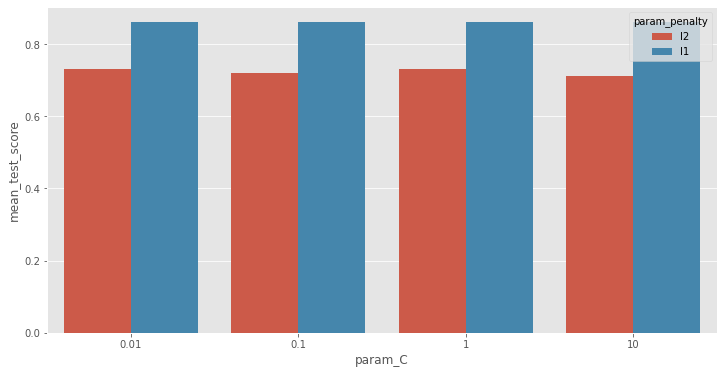

In [203]:
plt.figure(figsize=(12, 6))

sns.barplot(x='param_C', y='mean_test_score', data=gs_result_lr, hue='param_penalty')
plt.show()

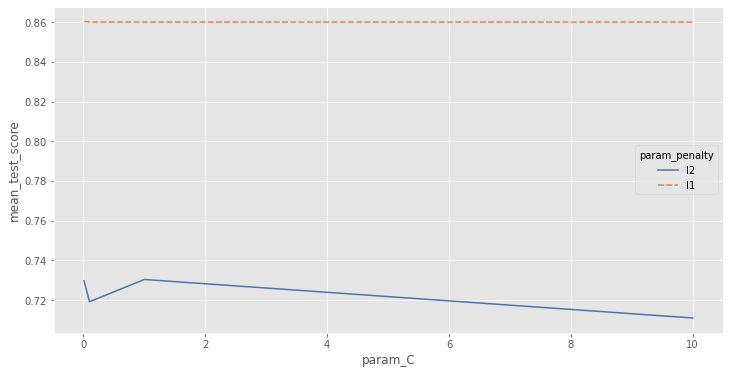

In [205]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_C', y='mean_test_score', data=gs_result_lr, 
             hue='param_penalty', style='param_penalty', palette='deep'
            )

plt.show()

In [149]:
grid_search_lr.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [150]:
best_lr = grid_search_lr.best_estimator_

In [202]:
def get_model_prfm(model, Xtest, Ytest):
    '''
    model: model that already has been fit
    Xtest: features of test set
    Ytest: labels of test set
    '''
    y_pred_model = model.predict(Xtest)
    accuracy = model.score(Xtest, Ytest)
    recall = recall_score(y_true=Ytest, y_pred=y_pred_model)
    precision = precision_score(y_true=Ytest, y_pred=y_pred_model)
    f1 = f1_score(y_true=Ytest, y_pred=y_pred_model)
    auc = roc_auc_score(y_true = Ytest, y_score = model.predict_proba(Xtest)[:,1])
    
    print('Accuracy: ' + '%.2f' %accuracy
         + '\n' + 'Recall: ' + '%.2f' %recall
         + '\n' + 'Precision: ' + '%.2f' %precision
         + '\n' + 'F1: ' + '%.2f' %f1
         + '\n' + 'AUC: ' + '%.2f' %auc
         ) 
    
    fig, ax = plt.subplots(1,2,figsize=(14,7))
        
    plot_confusion_matrix(model, X = Xtest, y_true = Ytest, cmap = 'Blues', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, thresholds = roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    plt.plot(fpr,tpr)
    ax[1].set_title('ROC-AUC')
    
    KS_max = 0
    best_thr = 0
    for i in range(len(fpr)):
        if(i == 0):
            KS_max = tpr[i] - fpr[i]
            best_thr = thresholds[i]
        elif (tpr[i] - fpr[i] > KS_max):
            KS_max = tpr[i] - fpr[i]
            best_thr = thresholds[i]

    print('MAX KS:' + '%.2f' %KS_max
         + '\n' + 'Best Threshold:' + '%.2f' %best_thr)
    plt.show()               

Accuracy: 0.79
Recall: 0.71
Precision: 0.85
F1: 0.77
AUC: 0.87
MAX KS:0.58
Best Threshold:0.48


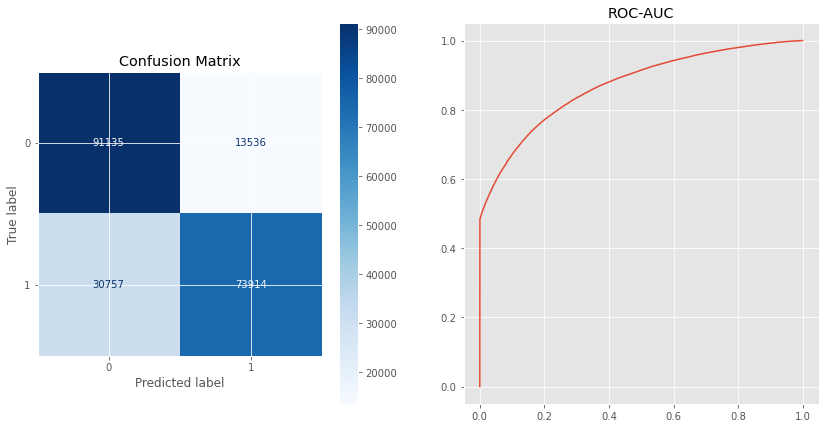

In [155]:
get_model_prfm(best_lr, Xtrain, Ytrain)

Accuracy: 0.76
Recall: 0.28
Precision: 0.35
F1: 0.31
AUC: 0.66
MAX KS:0.23
Best Threshold:0.30


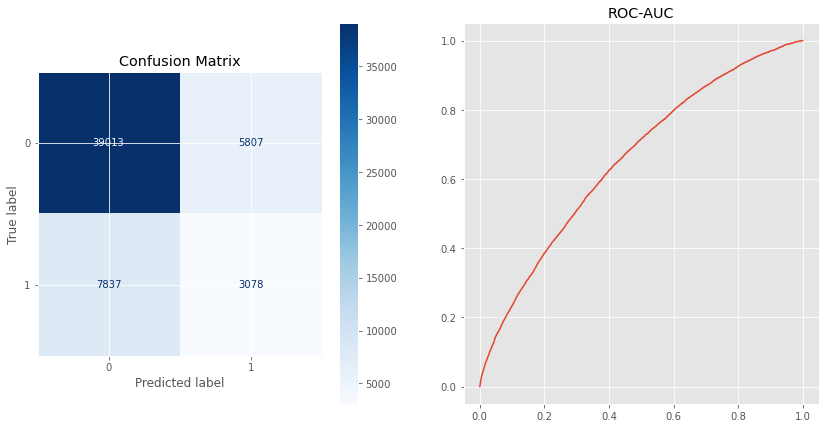

In [156]:
get_model_prfm(best_lr, Xtest, Ytest)

## RandomForest

In [163]:
%%time

param_grid_rf = {'n_estimators': [100, 200, 500,], 'criterion': ['gini', 'entropy',], 'max_depth':[3, 6, 9,]}

grid_search_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=2021),  param_grid_rf, cv=5, n_jobs=-1) 
grid_search_rf.fit(Xtrain, Ytrain)

CPU times: user 7min 20s, sys: 48.3 s, total: 8min 8s
Wall time: 22min 59s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2021),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]})

In [164]:
joblib.dump(filename='gs_rf.pkl',value=grid_search_rf)

['gs_rf.pkl']

In [208]:
gs_result_rf = pd.DataFrame(grid_search_rf.cv_results_)
gs_result_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,111.231270,4.496629,15.070927,4.835317,gini,3,100,"{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}",0.556020,0.758127,0.807872,0.802928,0.796885,0.744367,0.095796,17
1,255.998713,20.500195,21.569788,2.070515,gini,3,200,"{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}",0.553727,0.770546,0.820316,0.818835,0.810309,0.754747,0.102130,14
2,529.902326,53.686791,46.165250,13.221475,gini,3,500,"{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 500}",0.555184,0.770116,0.817044,0.817235,0.814847,0.754885,0.101449,13
3,156.728221,43.802421,22.206303,8.918019,gini,6,100,"{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}",0.539062,0.803793,0.866939,0.858555,0.863165,0.786303,0.125749,12
4,270.196745,42.519816,26.520147,7.062260,gini,6,200,"{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 200}",0.538011,0.810218,0.872838,0.866748,0.869590,0.791481,0.128828,10
5,654.177792,76.710067,63.852053,20.343629,gini,6,500,"{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 500}",0.537701,0.811794,0.870952,0.868802,0.870784,0.792007,0.129150,9
6,238.950038,40.345873,18.779741,3.588670,gini,9,100,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 100}",0.527049,0.828704,0.901357,0.897631,0.902431,0.811434,0.144893,5
7,371.433586,39.575191,30.434288,12.039243,gini,9,200,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}",0.527096,0.832071,0.903673,0.904868,0.903387,0.814219,0.146238,1
8,821.681237,42.454214,50.908587,12.679714,gini,9,500,"{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 500}",0.528744,0.831283,0.901357,0.903052,0.902479,0.813383,0.144954,2
9,168.200154,14.252351,14.551783,0.853656,entropy,3,100,"{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}",0.555590,0.756359,0.806081,0.802713,0.795739,0.743296,0.095527,18


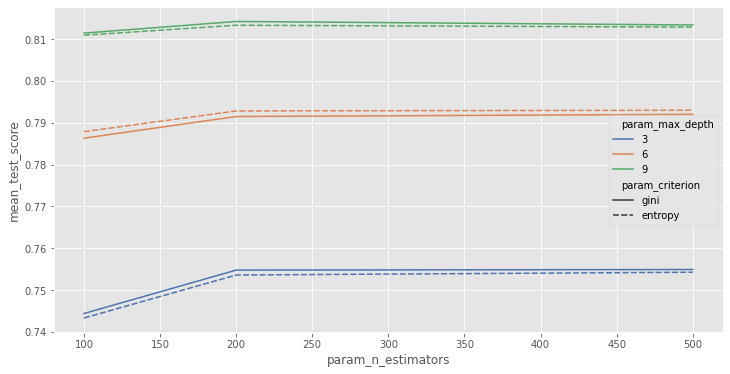

In [209]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_result_rf, hue='param_max_depth', style='param_criterion', palette='deep')
plt.show()

In [214]:
grid_search_rf.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}

In [215]:
best_rf = grid_search_rf.best_estimator_

Accuracy: 0.83
Recall: 0.75
Precision: 0.88
F1: 0.81
AUC: 0.90
MAX KS:0.65
Best Threshold:0.52


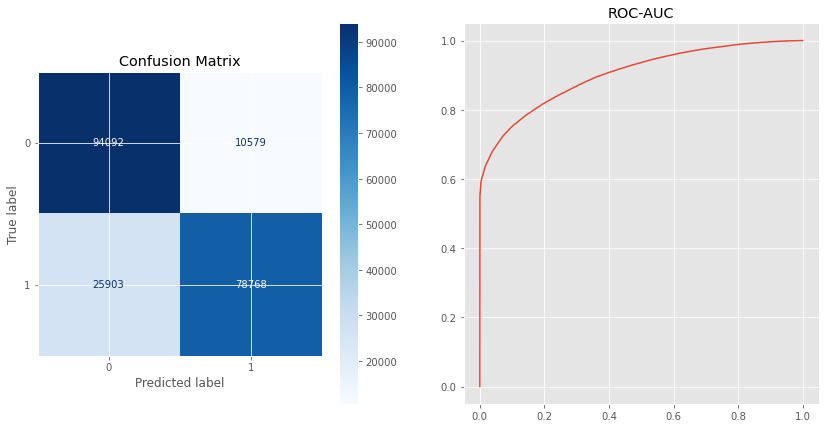

In [216]:
get_model_prfm(best_rf, Xtrain, Ytrain)

Accuracy: 0.76
Recall: 0.20
Precision: 0.33
F1: 0.25
AUC: 0.66
MAX KS:0.24
Best Threshold:0.31


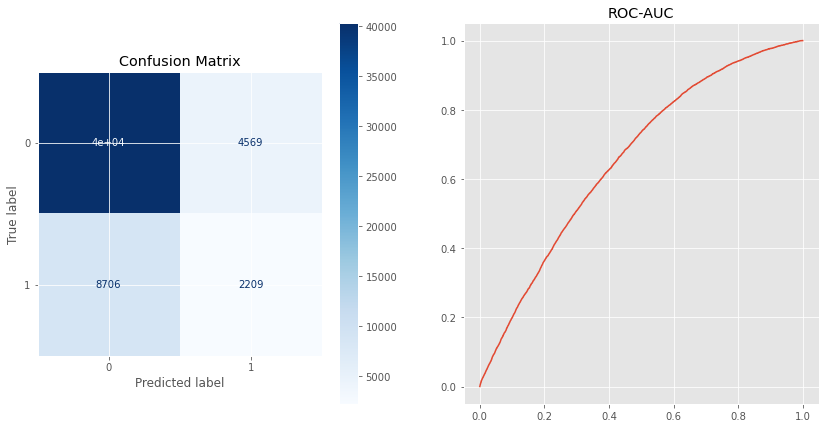

In [217]:
get_model_prfm(best_rf, Xtest, Ytest)

## GBDT

In [94]:
%%time

param_grid_gbdt = {'n_estimators': [100, 200, 500,], 'learning_rate': [0.01, 0.1, 1, 10,], 
                   'max_depth':[3, 6, 9,]
                  }

grid_search_gbdt = GridSearchCV(GradientBoostingClassifier(random_state=2021),  param_grid_gbdt, cv=5, n_jobs=-1) 
grid_search_gbdt.fit(Xtrain, Ytrain)

# Wall time: 3h 15min 45s

Wall time: 3h 15min 45s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]})

In [97]:
joblib.dump(filename='gs_gbdt.pkl',value=grid_search_gbdt)

['gs_gbdt.pkl']

In [158]:
grid_search_gbdt = joblib.load('gs_gbdt.pkl')

In [159]:
gs_result_gbdt = pd.DataFrame(grid_search_gbdt.cv_results_)
gs_result_gbdt

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,79.740840,2.964327,0.180921,0.014043,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}",0.514134,0.819367,0.883660,0.883634,0.890844,0.798328,0.144449,27
1,162.269103,4.068699,0.267295,0.006494,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}",0.509717,0.830564,0.890823,0.900131,0.902137,0.806674,0.150786,26
2,470.840979,10.970330,0.699148,0.049914,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",0.503963,0.851239,0.928162,0.928590,0.928948,0.828181,0.164852,20
3,188.469593,3.172168,0.316958,0.018161,0.01,6,100,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}",0.513919,0.841522,0.910352,0.919183,0.914337,0.819863,0.155595,25
4,403.884037,5.840561,0.640507,0.097850,0.01,6,200,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}",0.506494,0.854176,0.931409,0.932291,0.930739,0.831022,0.165004,19
5,980.445336,23.738303,1.365984,0.159706,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}",0.506112,0.861624,0.941269,0.942032,0.940981,0.838404,0.168997,14
6,267.389245,2.977450,0.492895,0.052335,0.01,9,100,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}",0.500477,0.850809,0.926061,0.928877,0.928662,0.826977,0.165958,21
7,557.025405,9.635425,0.936315,0.093504,0.01,9,200,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}",0.502340,0.858091,0.936303,0.938809,0.937424,0.834593,0.168952,17
8,1455.117934,35.133705,2.313439,0.213477,0.01,9,500,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}",0.506398,0.867020,0.948073,0.948024,0.946592,0.843222,0.171277,12
9,96.027194,3.837733,0.176132,0.014182,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.501982,0.859977,0.938404,0.939000,0.938689,0.835610,0.169578,16


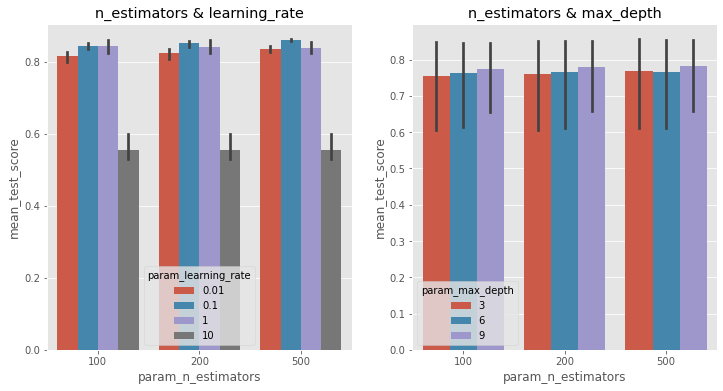

In [160]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.barplot(x='param_n_estimators', y='mean_test_score', data=gs_result_gbdt, hue='param_learning_rate', ax=ax[0])
ax[0].set_title('n_estimators & learning_rate')

sns.barplot(x='param_n_estimators', y='mean_test_score', data=gs_result_gbdt, hue='param_max_depth', ax=ax[1])
ax[1].set_title('n_estimators & max_depth')

plt.show()

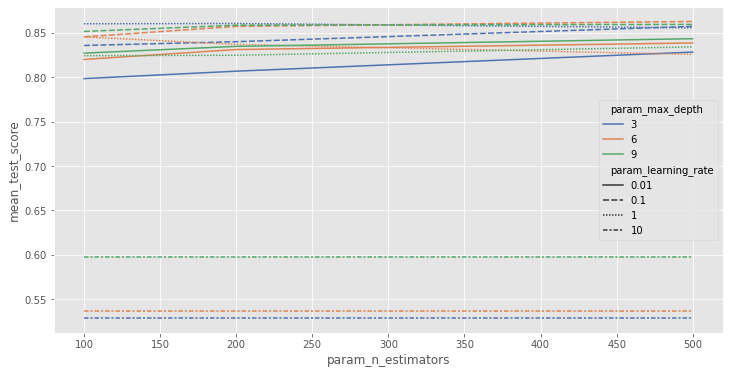

In [162]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_result_gbdt, 
             hue='param_max_depth', style='param_learning_rate', palette='deep'
            )

plt.show()

In [163]:
grid_search_gbdt.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

In [164]:
bets_gbdt = grid_search_gbdt.best_estimator_

Accuracy: 0.88
Recall: 0.77
Precision: 0.97
F1: 0.86
AUC: 0.93
MAX KS:0.75
Best Threshold:0.51


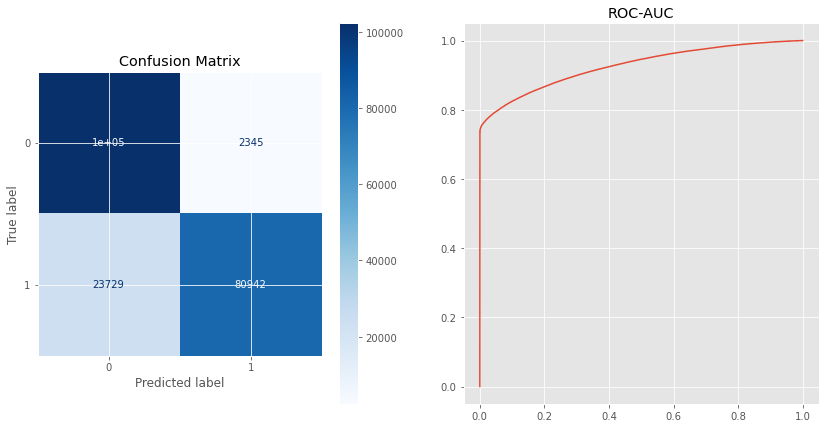

In [165]:
get_model_prfm(bets_gbdt, Xtrain, Ytrain)

Accuracy: 0.81
Recall: 0.09
Precision: 0.52
F1: 0.16
AUC: 0.70
MAX KS:0.29
Best Threshold:0.19


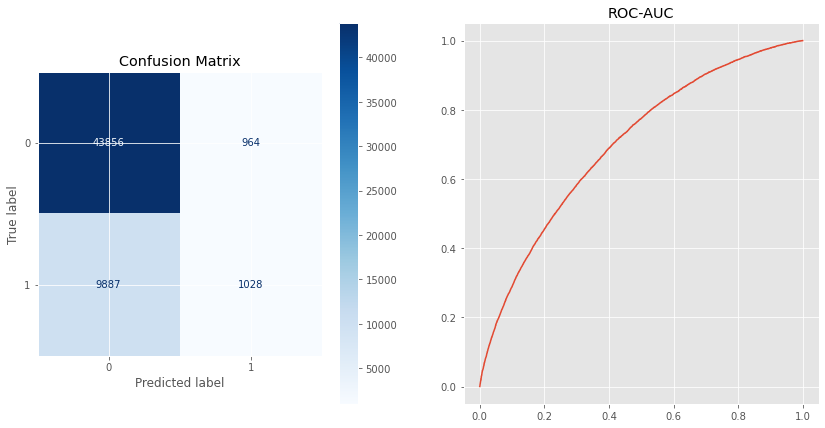

In [166]:
get_model_prfm(bets_gbdt, Xtest, Ytest)

## AdaBoost

In [123]:
%%time
param_grid_ada = {'base_estimator__max_depth': [3, 6, 9,], 'n_estimators': [100, 200, 500,], 'learning_rate': [0.01, 0.1, 1, 10,],             
                 }
dtc = DecisionTreeClassifier()
grid_search_ada = GridSearchCV(AdaBoostClassifier(base_estimator = dtc, random_state=2021),  param_grid_ada, 
                               scoring='roc_auc', cv=5, n_jobs=-1) 

grid_search_ada.fit(Xtrain, Ytrain)
# Wall time: 2h 43min 10s

CPU times: user 7min 47s, sys: 3.34 s, total: 7min 50s
Wall time: 2h 43min 10s


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=2021),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [3, 6, 9],
                         'learning_rate': [0.01, 0.1, 1, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='roc_auc')

In [125]:
joblib.dump(filename='gs_ada.pkl',value=grid_search_ada)

['gs_ada.pkl']

In [169]:
grid_search_ada = joblib.load(filename='gs_ada.pkl')

In [170]:
gs_result_ada = pd.DataFrame(grid_search_ada.cv_results_)
gs_result_ada

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,472.000623,8.450447,8.686362,0.115890,3,0.01,100,"{'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 100}",0.602030,0.900319,0.960144,0.961110,0.959237,0.876568,0.139214,27
1,956.987134,45.428351,17.166745,0.608074,3,0.01,200,"{'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}",0.623444,0.910469,0.971413,0.971934,0.970050,0.889462,0.135070,26
2,2331.158535,33.274330,39.836623,0.549379,3,0.01,500,"{'base_estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500}",0.643222,0.917878,0.978861,0.979422,0.978209,0.899518,0.130305,18
3,463.529073,9.422317,8.205148,0.107085,3,0.1,100,"{'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}",0.675499,0.930810,0.989747,0.993449,0.991026,0.916106,0.122577,3
4,933.810540,22.147872,17.045133,0.818545,3,0.1,200,"{'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}",0.687442,0.932507,0.995864,0.996900,0.996877,0.921918,0.119833,2
5,2324.017827,53.669331,38.202933,0.932129,3,0.1,500,"{'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 500}",0.682013,0.934734,0.998237,0.998659,0.998299,0.922388,0.122691,1
6,439.072896,22.238041,8.021740,0.215556,3,1,100,"{'base_estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 100}",0.650851,0.930159,0.995668,0.995920,0.996260,0.913771,0.133907,5
7,901.176283,42.657017,15.573413,0.324773,3,1,200,"{'base_estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 200}",0.625184,0.930116,0.996960,0.997657,0.998067,0.909597,0.144586,7
8,2202.794741,126.490547,38.306989,0.325211,3,1,500,"{'base_estimator__max_depth': 3, 'learning_rate': 1, 'n_estimators': 500}",0.583633,0.927090,0.998226,0.998650,0.998398,0.901199,0.161169,16
9,70.807302,1.825047,7.882402,0.364012,3,10,100,"{'base_estimator__max_depth': 3, 'learning_rate': 10, 'n_estimators': 100}",0.461427,0.696610,0.784779,0.783319,0.789981,0.703223,0.125780,34


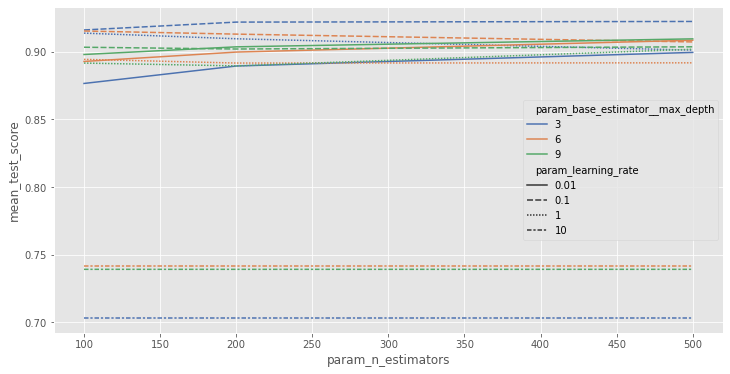

In [172]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_result_ada, 
             hue='param_base_estimator__max_depth', style='param_learning_rate', palette='deep'
            )
plt.show()

In [173]:
grid_search_ada.best_params_

{'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 500}

In [174]:
bets_ada = grid_search_ada.best_estimator_

Accuracy: 0.88
Recall: 0.77
Precision: 0.99
F1: 0.87
AUC: 0.93
MAX KS:0.76
Best Threshold:0.50


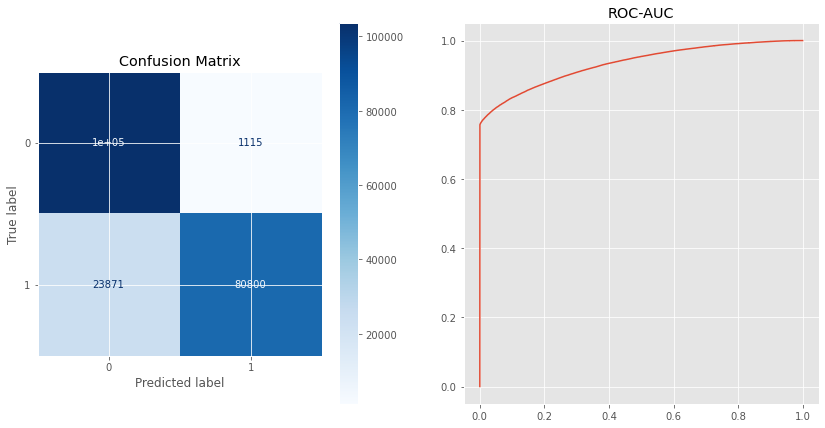

In [175]:
get_model_prfm(bets_ada, Xtrain, Ytrain)

Accuracy: 0.81
Recall: 0.06
Precision: 0.54
F1: 0.11
AUC: 0.70
MAX KS:0.29
Best Threshold:0.49


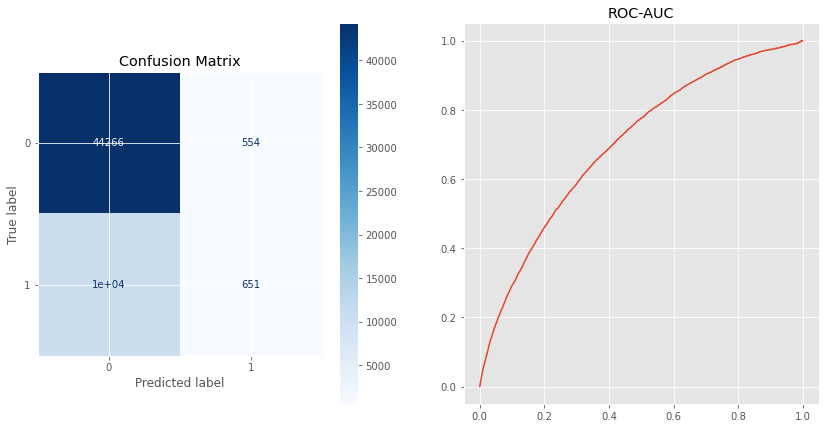

In [176]:
get_model_prfm(bets_ada, Xtest, Ytest)

## LightGBM

In [132]:
%%time

param_grid_lgb = {'n_estimators': [100, 200, 500,], 'learning_rate': [0.01, 0.1, 1, 10,], 
                   'max_depth':[3, 6, 9,]
                  }

grid_search_lgb = GridSearchCV(LGBMClassifier(random_state=2021),  param_grid_lgb, cv=5, n_jobs=-1) 
grid_search_lgb.fit(Xtrain, Ytrain)

CPU times: user 7min 42s, sys: 36.1 s, total: 8min 18s
Wall time: 4min 52s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=2021), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]})

In [133]:
joblib.dump(filename='gs_lgb.pkl',value=grid_search_lgb)

['gs_lgb.pkl']

In [177]:
grid_search_lgb = joblib.load(filename='gs_lgb.pkl')

In [178]:
gs_result_lgb = pd.DataFrame(grid_search_lgb.cv_results_)
gs_result_lgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.762268,1.254443,1.396454,0.151302,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}",0.512718,0.818935,0.888029,0.883969,0.891086,0.798947,0.145589,27
1,32.029868,2.922325,2.528160,0.108792,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}",0.511691,0.824715,0.890609,0.892185,0.889343,0.801709,0.147247,26
2,72.411891,5.774328,8.225594,0.061389,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",0.504311,0.847739,0.927439,0.928776,0.925480,0.826749,0.164136,22
3,26.694955,0.264718,1.518463,0.099288,0.01,6,100,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}",0.509088,0.839547,0.913156,0.915401,0.914398,0.818318,0.157305,25
4,51.219174,4.786969,4.116822,0.176534,0.01,6,200,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}",0.507129,0.846330,0.925146,0.925934,0.923665,0.825641,0.162140,24
5,104.017011,1.668121,11.340194,0.118894,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}",0.504622,0.858869,0.939214,0.941817,0.939691,0.836843,0.169076,16
6,28.328582,3.040658,1.543425,0.093517,0.01,9,100,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}",0.500012,0.844658,0.926674,0.929278,0.928872,0.825899,0.166133,23
7,52.527263,5.310082,4.209365,0.160308,0.01,9,200,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}",0.500943,0.851131,0.935989,0.941172,0.937709,0.833389,0.169624,20
8,120.242256,11.440499,11.468519,0.271378,0.01,9,500,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}",0.504168,0.861091,0.943441,0.945758,0.942725,0.839436,0.170683,14
9,17.090733,1.280775,1.341917,0.059155,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.503666,0.857269,0.937613,0.939787,0.937327,0.835133,0.168676,19


In [179]:
gs_result_lgb[gs_result_lgb['rank_test_score']==1]['params']

14    {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}
Name: params, dtype: object

In [180]:
bets_lgb = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=2021, n_jobs=-1)
bets_lgb.fit(Xtrain, Ytrain)

LGBMClassifier(max_depth=6, n_estimators=500, random_state=2021)

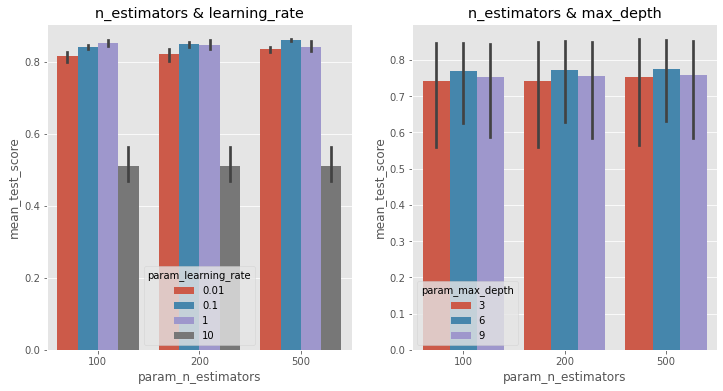

In [181]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.barplot(x='param_n_estimators', y='mean_test_score', data=gs_result_lgb, hue='param_learning_rate', ax=ax[0])
ax[0].set_title('n_estimators & learning_rate')

sns.barplot(x='param_n_estimators', y='mean_test_score', data=gs_result_lgb, hue='param_max_depth', ax=ax[1])
ax[1].set_title('n_estimators & max_depth')

plt.show()

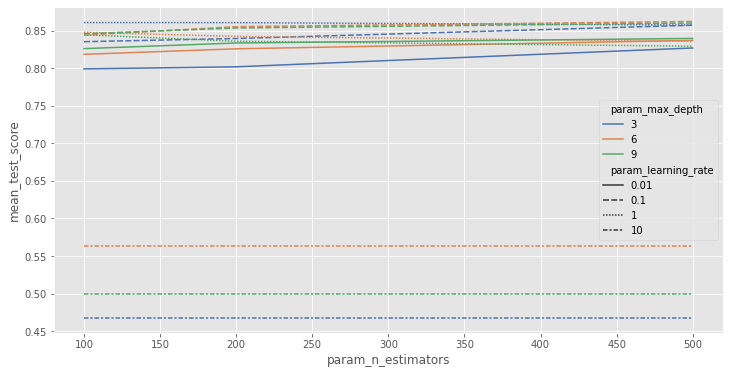

In [182]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_result_lgb, 
             hue='param_max_depth', style='param_learning_rate', palette='deep')

plt.show()

Accuracy: 0.89
Recall: 0.78
Precision: 0.98
F1: 0.87
AUC: 0.95
MAX KS:0.78
Best Threshold:0.43


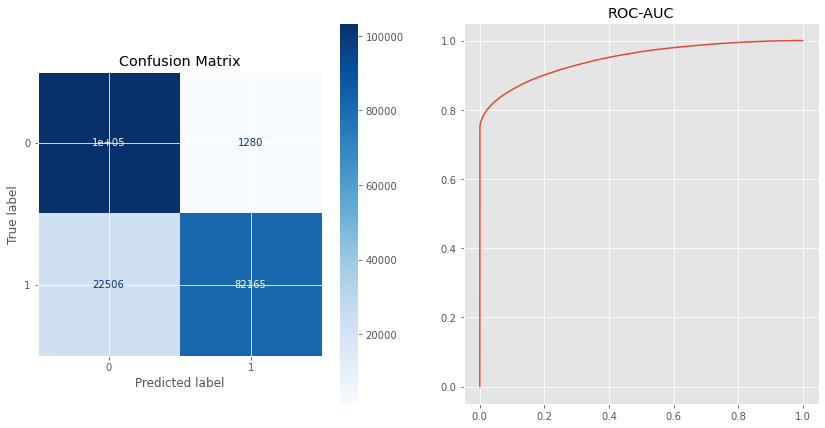

In [183]:
get_model_prfm(bets_lgb, Xtrain, Ytrain)

Accuracy: 0.80
Recall: 0.09
Precision: 0.49
F1: 0.14
AUC: 0.69
MAX KS:0.28
Best Threshold:0.22


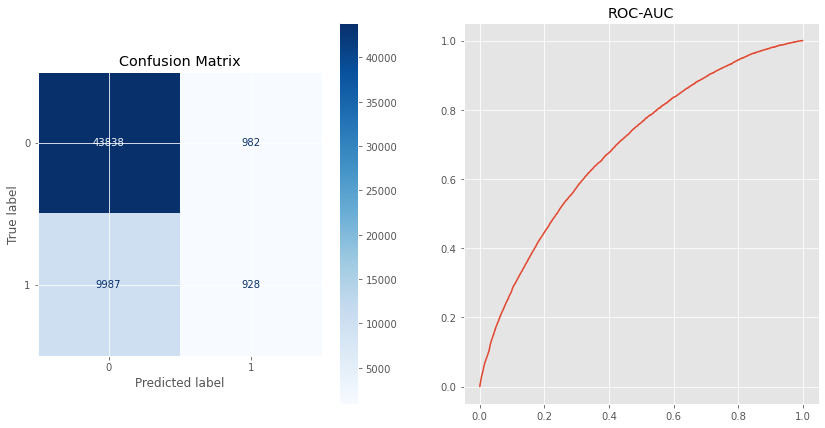

In [184]:
get_model_prfm(bets_lgb, Xtest, Ytest)

## XGBoost

In [189]:
%%time

param_grid_xgb = {'n_estimators': [100, 200, 500,], 'learning_rate': [0.01, 0.1, 1, 10,], 
                   'max_depth':[3, 6, 9,]
                  }

grid_search_xgb = GridSearchCV(XGBClassifier(random_state=2021, n_jobs=-1),  param_grid_xgb, cv=5, n_jobs=-1) 
grid_search_xgb.fit(Xtrain, Ytrain)

# Wall time: 22h 44min 28s

[07:10:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 1h 44min 32s, sys: 10min, total: 1h 54min 32s
Wall time: 22h 44min 23s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=2021,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [190]:
joblib.dump(filename='gs_xgb.pkl',value=grid_search_xgb)

['gs_xgb.pkl']

In [192]:
gs_result_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
gs_result_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2464.318900,18.569604,3.050647,0.511990,0.01,3,100,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}",0.512718,0.818935,0.888172,0.884422,0.888698,0.798589,0.145360,27
1,4982.401613,51.664185,4.931169,1.204702,0.01,3,200,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}",0.512360,0.824787,0.890489,0.891851,0.889176,0.801732,0.146910,26
2,12297.629613,34.028692,5.263144,1.076165,0.01,3,500,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",0.504311,0.847787,0.928107,0.929397,0.925934,0.827107,0.164351,22
3,6659.345059,150.630818,4.810104,1.279168,0.01,6,100,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}",0.509136,0.841052,0.914398,0.916619,0.915449,0.819331,0.157756,25
4,13683.073840,353.535935,5.039764,0.789038,0.01,6,200,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}",0.507105,0.846474,0.924764,0.928466,0.925193,0.826400,0.162607,23
5,34077.714946,352.376416,5.581847,1.122849,0.01,6,500,"{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}",0.504192,0.859084,0.939763,0.942510,0.940050,0.837120,0.169447,15
6,12887.133282,154.190852,4.557870,0.551062,0.01,9,100,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100}",0.500920,0.843464,0.916786,0.923163,0.921229,0.821112,0.162858,24
7,26235.031889,175.861156,5.444401,1.227705,0.01,9,200,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200}",0.501493,0.854021,0.930782,0.935703,0.932789,0.830958,0.167562,19
8,64099.652241,369.729313,8.469975,1.618843,0.01,9,500,"{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}",0.504001,0.865318,0.943632,0.944636,0.943919,0.840301,0.170894,12
9,2455.185805,42.322468,4.078818,1.612922,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.502926,0.857150,0.939094,0.940265,0.937590,0.835405,0.169236,16


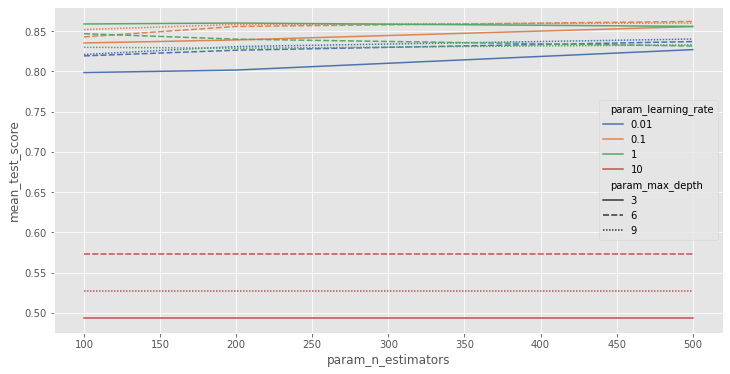

In [195]:
plt.figure(figsize=(12,6))

sns.lineplot(x='param_n_estimators', y='mean_test_score', data=gs_result_xgb, 
             hue='param_learning_rate', style='param_max_depth', palette='deep')

plt.show()

In [196]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}

In [197]:
best_xgb = grid_search_xgb.best_estimator_

Accuracy: 0.89
Recall: 0.79
Precision: 0.99
F1: 0.88
AUC: 0.95
MAX KS:0.79
Best Threshold:0.42


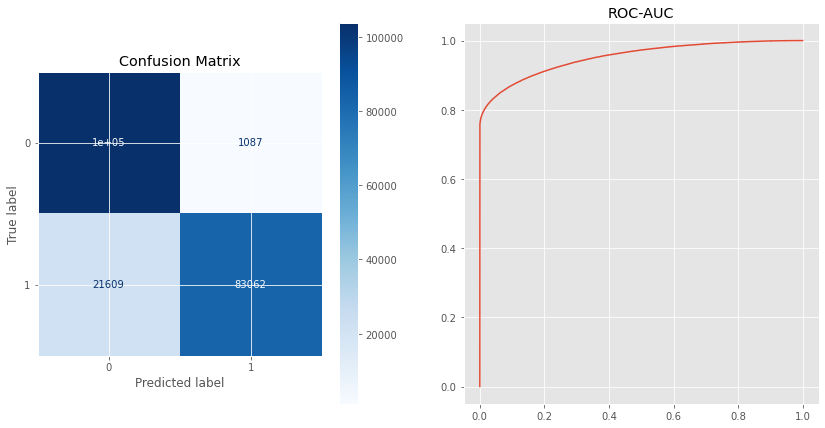

In [198]:
get_model_prfm(best_xgb, Xtrain, Ytrain)

Accuracy: 0.80
Recall: 0.08
Precision: 0.47
F1: 0.14
AUC: 0.69
MAX KS:0.28
Best Threshold:0.21


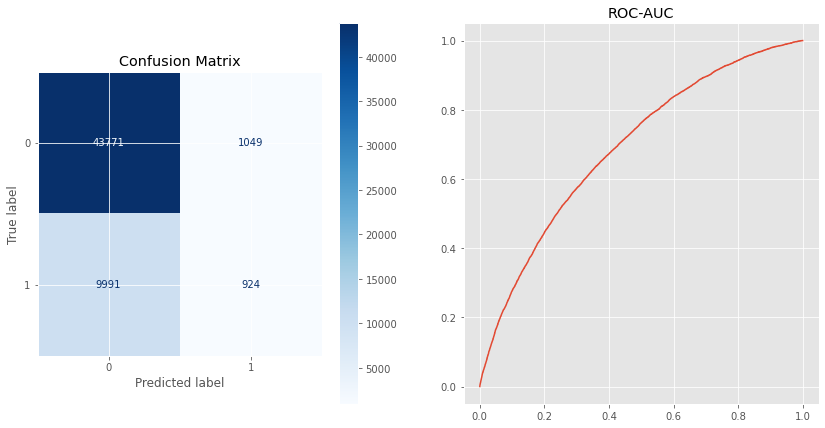

In [199]:
get_model_prfm(best_xgb, Xtest, Ytest)

## CatBoost

In [155]:
CatBoostClassifier()

In [ ]:
%%time

param_grid_ctb = {'iterations': [100, 200, 500,], 'learning_rate': [0.01, 0.1, 1, 10,], 
                   'max_depth':[3, 6, 9,]
                  }

grid_search_ctb = GridSearchCV(CatBoostClassifier(random_seed=2021),  param_grid_ctb, cv=5, 
                            #   n_jobs=1
                              ) 
grid_search_ctb.fit(Xtrain, Ytrain)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6773964	total: 39.9ms	remaining: 3.95s
1:	learn: 0.6625035	total: 63.9ms	remaining: 3.13s
2:	learn: 0.6535976	total: 86.7ms	remaining: 2.8s
3:	learn: 0.6397944	total: 108ms	remaining: 2.6s
4:	learn: 0.6368002	total: 127ms	remaining: 2.42s
5:	learn: 0.6283317	total: 150ms	remaining: 2.35s
6:	learn: 0.6203305	total: 173ms	remaining: 2.29s
7:	learn: 0.6079021	total: 197ms	remaining: 2.26s
8:	learn: 0.6052378	total: 216ms	remaining: 2.18s
9:	learn: 0.6026336	total: 235ms	remaining: 2.12s
10:	learn: 0.6000885	total: 280ms	remaining: 2.27s
11:	learn: 0.5886534	total: 302ms	remaining: 2.22s
12:	learn: 0.5862848	total: 321ms	remaining: 2.15s
13:	learn: 0.5839699	total: 339ms	remaining: 2.08s
14:	learn: 0.5771100	total: 362ms	remaining: 2.05s
15:	learn: 0.5706040	total: 386ms	remaining: 2.02s
16:	learn: 0.5684306	total: 405ms	remaining: 1.98s
17:	learn: 0.5665200	total: 424ms	remaining: 1.93s
18:	learn: 0.5644293	total: 445ms	remaining: 1.9s
19:	learn: 0.5583316	total: 476ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
